<a href="https://colab.research.google.com/github/hdev90/LSTM/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 60, 50)            11200     
_________________________________________________________________
dropout_48 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 60, 60)            26640     
_________________________________________________________________
dropout_49 (Dropout)         (None, 60, 60)            0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 60, 80)            45120     
_________________________________________________________________
dropout_50 (Dropout)         (None, 60, 80)            0         
__________________________________________________

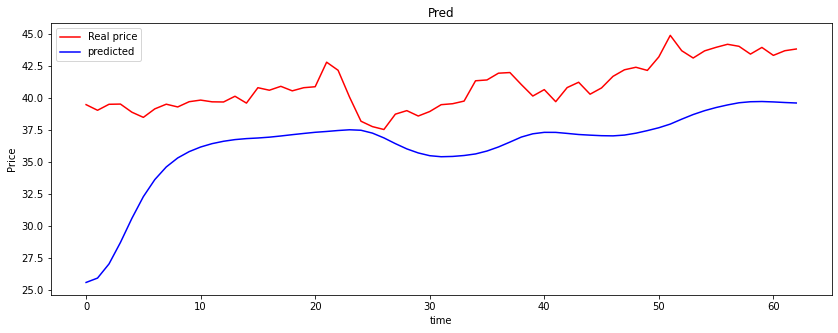

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,load_model
from keras.layers import LSTM, Dense,Dropout
import os
from sklearn.model_selection import TimeSeriesSplit
#Data Gathering

import yfinance as yf
data = yf.download("AAPL", start="2011-01-01", end="2019-09-30")
data_training=data.loc['2011-01-01':'2018-12-31'].copy()
training_data=data_training.drop(['Adj Close'],axis=1)

data_validate=data.loc['2019-01-01':'2019-06-30'].copy()
data_test=data.loc['2019-07-01':].copy()

#Scaling training and testing data
scaler=MinMaxScaler()
training_data=scaler.fit_transform(training_data)
X_train=[]
y_train=[]
for i in range(60,training_data.shape[0]):##window 60 days
  X_train.append(training_data[i-60:i])
  y_train.append(training_data[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)

##model## Building LSTM
regressior=Sequential()
regressior.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1],5)))
regressior.add(Dropout(0.2))

regressior.add(LSTM(units=60,activation='relu',return_sequences=True))
regressior.add(Dropout(0.3))

regressior.add(LSTM(units=80,activation='relu',return_sequences=True))
regressior.add(Dropout(0.4))

regressior.add(LSTM(units=120,activation='relu'))
regressior.add(Dropout(0.5))

regressior.add(Dense(units=1))
regressior.summary()
regressior.compile(optimizer='adam',loss='mean_squared_error')
#Fitting data
regressior.fit(X_train,y_train,epochs=100,batch_size=50)
past_60_days=data_training.tail(60)
df=past_60_days.append(data_test,ignore_index=True)
df=df.drop(['Adj Close'],axis=1)
inputs=scaler.transform(df)

X_test=[]
y_test=[]
for i in range(60,inputs.shape[0]):
  X_test.append(inputs[i-60:i])
  y_test.append(inputs[i,0])
X_test,y_test=np.array(X_test),np.array(y_test)
y_pred=regressior.predict(X_test)
scale=1/scaler.scale_[0]
y_pred=y_pred*scale
y_test=y_test*scale

##Visualization
plt.figure(figsize=(14,5))
plt.plot(y_test,color='red',label='Real price')
plt.plot(y_pred,color='blue',label='predicted')
plt.title('Pred')
plt.xlabel('time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
#Validation Step
data_validate=data_validate.drop(['Adj Close'],axis=1)
validate_data=scaler.transform(data_validate)

X_validate=[]
Y_validate=[]
for i in range(60,validate_data.shape[0]):
  X_validate.append(validate_data[i-60:i])
  Y_validate.append(validate_data[i,0])
X_validate,Y_validate=np.array(X_validate),np.array(Y_validate)


#Chaining
tscv = TimeSeriesSplit()
predictions=[]
true_values=[]

for train_index,test_index in tscv.split(X_validate):
  X_V_train, X_V_test = X_validate[train_index], X_validate[test_index]
  y_V_train, y_V_test = Y_validate[train_index], Y_validate[test_index]
  regressior.fit(X_V_train,y_V_train,epochs=100)
  predictions.append(regressior.predict([X_V_test])[0])
  true_values.append(y_V_test[0])

Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0046
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0042
Epoch 9/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 10/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0079
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 13/100
1/1 [==============================] - 0s 1ms/st

In [ ]:
import math
from sklearn.metrics import mean_squared_error
scale=1/scaler.scale_[0]
predictions=[i*scale for i in predictions]
true_values=[i*scale for i in true_values]
rmse=math.sqrt(mean_squared_error(predictions,true_values))
rmse

2.478733470597273